### 1. Preprocess the data such as highly-variable gene filtering

See https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html for preprocessing

Use dandelion/dandelion/preprocessing/external/_preprocessing.py/recipe_scannpy_qc function to do preprocessing

<span style="color:yellow">**Attemp 1:**</span> find out common genes among all AnnData objects and then filter for highly-variable genes

In [1]:
# Environment set-up
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as anndata
import scipy as scipy
import seaborn as sbn
import matplotlib.pyplot as plt
from dandelion.preprocessing.external._preprocessing import recipe_scanpy_qc

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load all AnnData objects into a list

from pathlib import Path
from itertools import chain

GSE132509_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE132509')
GSE236351_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE236351')
GSE148218_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE148218')

combined_dirs = chain(GSE132509_directory.iterdir(), GSE236351_directory.iterdir(), GSE148218_directory.iterdir())
adatas = []
for adata_path in combined_dirs:
    if "_uni.h5ad" in adata_path.name:
        adata = anndata.read_h5ad(adata_path)
        adatas.append(adata)

print(len(adatas))
print(adatas[0])

26
AnnData object with n_obs × n_vars = 2229 × 33694
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode'
    var: 'gene_ids'


In [9]:
# Find out common genes among all AnnData objects
common_genes = set(adatas[0].var_names)
for adata in adatas[1:]:
    common_genes.intersection_update(adata.var_names)
    print(len(common_genes))

33694
33694
33694
33694
33694
33694
33694
33694
33694
33694
14889
14718
14718
14718
14718
14718
14718
14071
14071
14071
14071
14071
14071
14071
14071


In [11]:
# Filter all AnnData objects with common genes
adatas_common_genes = []
for adata in adatas:
    adata_common_genes = adata[:, list(common_genes)]
    print(adata_common_genes.shape)
    adatas_common_genes.append(adata_common_genes)

(2229, 14071)
(1612, 14071)
(2748, 14071)
(3105, 14071)
(5069, 14071)
(3728, 14071)
(5013, 14071)
(6274, 14071)
(2776, 14071)
(2959, 14071)
(3862, 14071)
(1712, 14071)
(6916, 14071)
(6523, 14071)
(3731, 14071)
(3726, 14071)
(2942, 14071)
(4293, 14071)
(6123, 14071)
(4163, 14071)
(7826, 14071)
(7917, 14071)
(7160, 14071)
(4224, 14071)
(6106, 14071)
(7228, 14071)


In [13]:
# Do the preprocessing

# Use a dictionary to store AnnData objects (Key: sample_name, Value: filtered_anndata)
adatas_filtered = [] 

for adata in adatas_common_genes:
    adata.raw = adata
    print(adata.shape)

    # Do QC and filtering
    recipe_scanpy_qc(adata)
    adata = adata[adata.obs.filter_rna == 'False', :]
    print(adata.shape)

    # Do normalization
    sc.pp.normalize_total(adata, target_sum=1.0)

    # Do the log transformation
    sc.pp.log1p(adata)

    # Select highky-variable genes
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=5000,
        batch_key='dataset'
    )
    adata = adata[:, adata.var.highly_variable]
    print(adata.shape)

    # Do the scaling
    sc.pp.scale(adata, max_value=10)

    adatas_filtered.append(adata)

(2229, 14071)
(332, 14071)
(332, 5000)
(1612, 14071)
(1243, 14071)
(1243, 5000)
(2748, 14071)
(1105, 14071)
(1105, 5000)
(3105, 14071)
(2181, 14071)
(2181, 5000)
(5069, 14071)
(3579, 14071)
(3579, 5000)
(3728, 14071)
(3245, 14071)
(3245, 5000)
(5013, 14071)
(2377, 14071)
(2377, 5000)
(6274, 14071)
(4200, 14071)
(4200, 5000)
(2776, 14071)
(2501, 14071)
(2501, 5000)
(2959, 14071)
(2523, 14071)
(2523, 5000)
(3862, 14071)
(1210, 14071)
(1210, 5000)
(1712, 14071)
(1267, 14071)
(1267, 5000)
(6916, 14071)
(6513, 14071)
(6513, 5000)
(6523, 14071)
(5104, 14071)
(5104, 5000)
(3731, 14071)
(3515, 14071)
(3515, 5000)
(3726, 14071)
(2377, 14071)
(2377, 5000)
(2942, 14071)
(2421, 14071)
(2421, 5000)
(4293, 14071)
(4150, 14071)
(4150, 5000)
(6123, 14071)
(680, 14071)
(680, 5000)
(4163, 14071)
(3266, 14071)
(3266, 5000)
(7826, 14071)
(6430, 14071)
(6430, 5000)
(7917, 14071)
(5790, 14071)
(5790, 5000)
(7160, 14071)
(5700, 14071)
(5700, 5000)
(4224, 14071)
(2843, 14071)
(2843, 5000)
(6106, 14071)
(4148,

In [21]:
# Concatenate "raw" AnnData objects to examine the performance of integration
adata_unintegrated = sc.AnnData.concatenate(*adatas_filtered)

In [15]:
print(len(adatas_filtered))
print(adatas_filtered[0])

26
AnnData object with n_obs × n_vars = 332 × 5000
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg'


### 2. Integration with Scanorama

See https://github.com/brianhie/scanorama for more info

In [16]:
import scanorama

# Integration and batch correction.
corrected = scanorama.correct_scanpy(adatas_filtered, return_dimred=True)

Found 203 genes among all datasets
[[0.         0.43072289 0.23795181 0.09638554 0.19277108 0.23493976
  0.1626506  0.13855422 0.04819277 0.0813253  0.12048193 0.12951807
  0.1626506  0.09036145 0.03313253 0.06024096 0.03915663 0.11445783
  0.01506024 0.01506024 0.14759036 0.04819277 0.05421687 0.02108434
  0.04819277 0.05722892]
 [0.         0.         0.13676589 0.13676589 0.08447305 0.24456959
  0.06596943 0.10860821 0.04827031 0.07562349 0.02892562 0.1207577
  0.1391794  0.12952534 0.05470636 0.05229284 0.04907482 0.03861625
  0.00735294 0.0458568  0.09573612 0.27514079 0.08286404 0.02493966
  0.04344328 0.14481094]
 [0.         0.         0.         0.11493213 0.08144796 0.27873303
  0.11493213 0.16651584 0.08868778 0.1638009  0.03348416 0.1321267
  0.24434389 0.10859729 0.1040724  0.04886878 0.04886878 0.07873303
  0.00588235 0.06425339 0.06606335 0.10859729 0.04615385 0.03348416
  0.03076923 0.03710407]
 [0.         0.         0.         0.         0.1824851  0.0343879
  0.00825

In [17]:
# Concatenate the integrated AnnData objects
adata_integrated = sc.AnnData.concatenate(*corrected)
print(adata_integrated)

AnnData object with n_obs × n_vars = 84157 × 203
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection', 'gene_ids-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'gene_ids-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1', 'gene_ids-10', 'means-10', 'dispersions-10', 'dispersions_norm-10', 'mean-10', 'std-10', 'gene_ids-11', 'means-11', 'dispersions-11', 'dispersions_norm-11', 'mean-11', 'std-11', 'feature_types-11', 'gene_ids-12', 'means-12', 'dispersions-12', 'dispersions_norm-12', 'mean-12', 'std-12', 'feature_types-12', 'gene_ids-13', 'means-13', 'dispersions-13', 'dispersions_norm-13', 'mean-13', 'std-13', 'feature_types-13', 'gene_ids-14', 'means-14', 'dispersions-14', 'disper

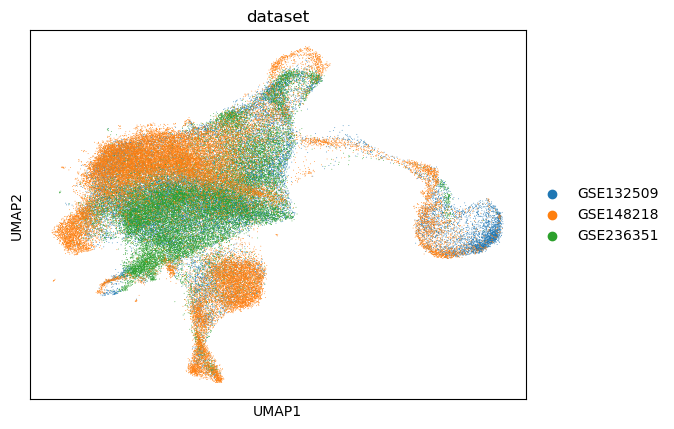

In [18]:
# Another way to do UMAP by computing KNN graph first

sc.pp.neighbors(adata_integrated, use_rep='X_scanorama')
sc.tl.umap(adata_integrated)
sc.pl.umap(adata_integrated, color=['dataset'])

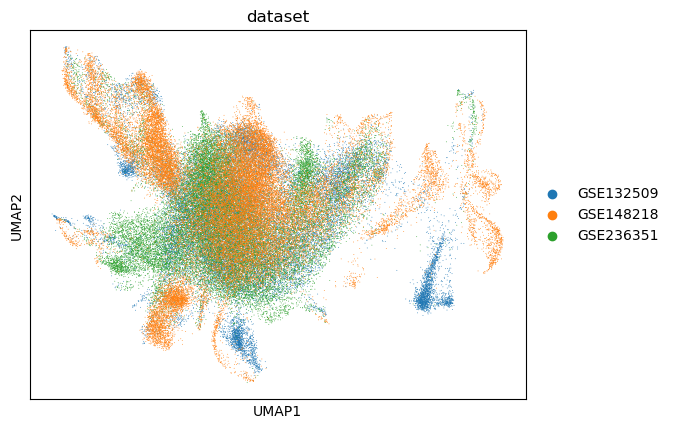

In [22]:
# Before integration
sc.tl.pca(adata_unintegrated) # Calculate the PCA embeddings
sc.pp.neighbors(adata_unintegrated) # Determine the kNN graph
sc.tl.umap(adata_unintegrated) # Calculate the UMAP

sc.pl.umap(adata_unintegrated, color=['dataset'])